In [1]:
import numpy as np
import time, sys, os, copy
import matplotlib
import matplotlib.pyplot as plt
import itertools

from tuning.cyMINoncyclic import mc_mean_grad_noncyclic, mc_coeff_arimoto  # poisson models
from tuning.bandit_sgd_poisson import simple_sgd_poisson

# from tuning.functions_for_analysis import gen_binary_hierachical_curves
from tuning.anim_3dcube import pc_fun_weights, plot_funcs_in_figure


In [18]:
## if using python 3

from tuning.anim_3dcube import create_figure_canvas, set_data_in_figure, get_color_array, gen_mixed_plots, gen_mixed_anim


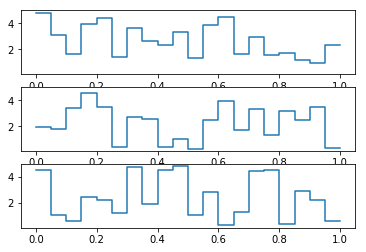

In [4]:
fp = 5.0
fm = 0.1
numNeuro = 3
numBin = 20
tuning0 = np.random.uniform(fm, fp, (numNeuro, numBin))
weight0 = 1.0*np.ones(numBin)/numBin
weight0 /= np.sum(weight0)

fig = plt.figure()
_ = plot_funcs_in_figure(fig, tuning0, weight0, nrow=numNeuro, ncol=1, 
                         fp = fp + 0.01, fm = fm - 0.01)



In [5]:
grad_tc = np.zeros_like(tuning0)
conv = np.zeros(tuning0.shape[1])# numBin
conv[0] = 1.0
tau = 1.0
# info_tc = 0
info_tc0 = mc_mean_grad_noncyclic(grad_tc, tuning0, weight0, conv, tau, int(1e6), my_num_threads = 24)
print(info_tc0)

0.9023780681614647


In [6]:
tuning_list = [tuning0.copy()]
weight_list = [weight0.copy()]
mark_list = [0]
sgd_learning_rate_list = [0]
sgd_batch_size_list = [0]
ba_batch_size_list = [0]
# bandit_learning_rate_list = [0]

tuning = tuning0.copy()
weight = weight0.copy()

info_list = [info_tc0]
grad_list = [grad_tc.copy()]
time_list = [0]
laplacian_coeff_list = [0]
sgd_iter_steps_list = [0]
ba_iter_steps_list = [0]

In [33]:
# m = 1
# tuning_list = tuning_list[0:m]#[tuning_list[0].copy()][tuning_list[1].copy()]
# weight_list = weight_list[0:m]

# info_list = info_list[0:m]
# grad_list = grad_list[0:m]
# time_list = time_list[0:m]
# mark_list = mark_list[0:m]

# sgd_learning_rate_list = sgd_learning_rate_list[0:m]
# sgd_batch_size_list = sgd_batch_size_list[0:m]
# sgd_iter_steps_list = sgd_iter_steps_list[0:m]
# ba_batch_size_list = ba_batch_size_list[0:m]
# ba_iter_steps_list = ba_iter_steps_list[0:m]
# laplacian_coeff_list = laplacian_coeff_list[0:m]

# tuning = tuning_list[-1].copy()
# weight = weight_list[-1].copy()

<IPython.core.display.Javascript object>


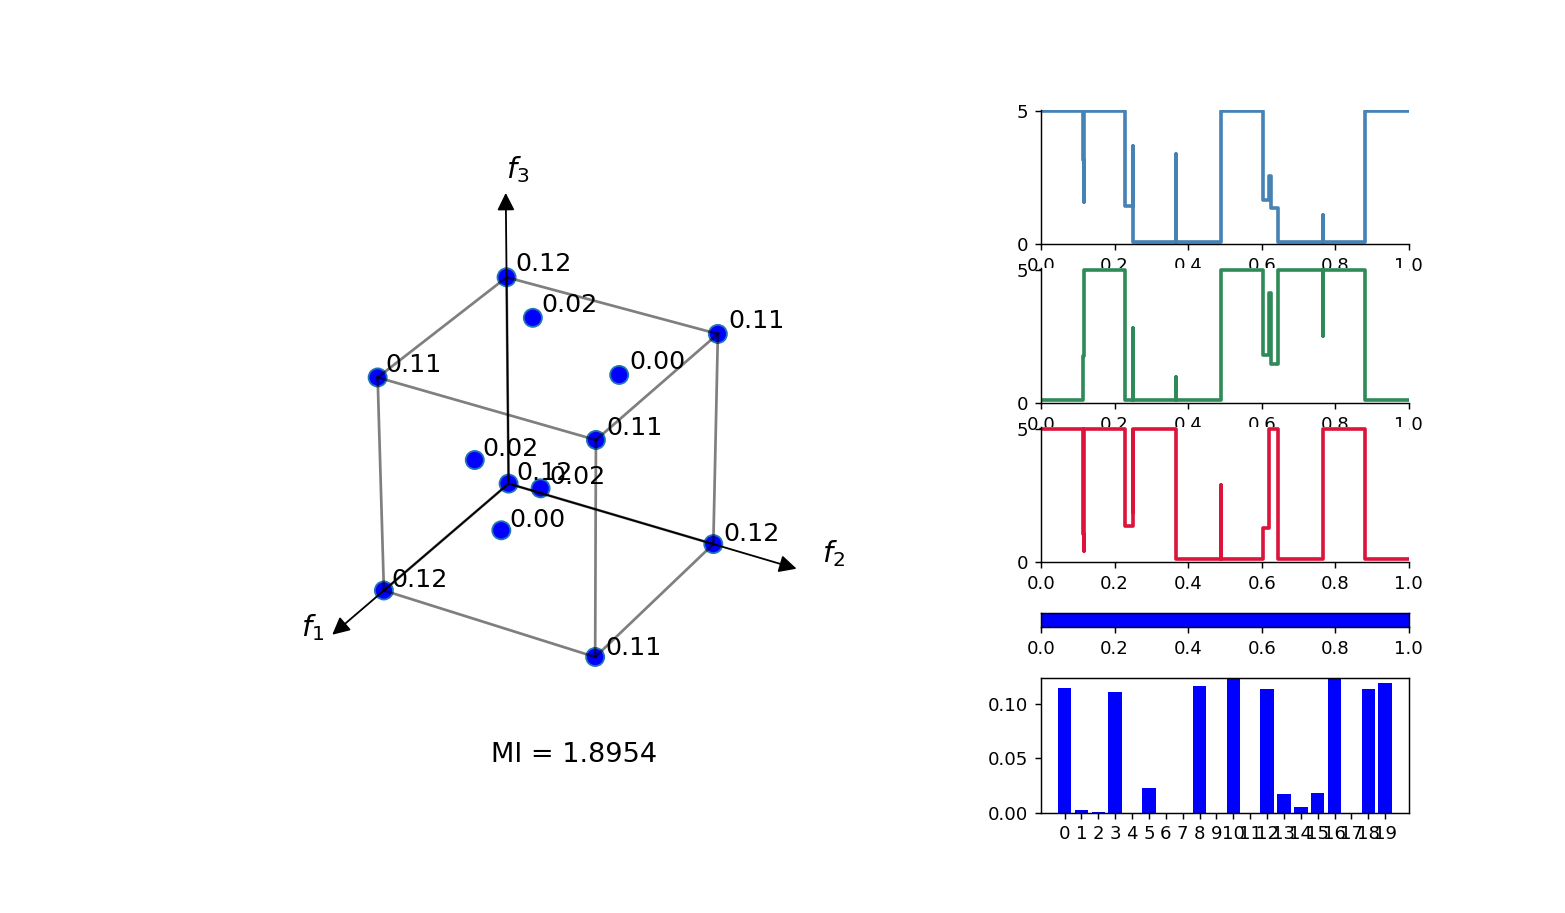

1 1000 1.8946002283482943 0.09247684478759766 0.06128334999084473
2 1000 1.8945336767724037 0.06925082206726074 0.04015684127807617
3 1000 1.8951768608313821 0.05326366424560547 0.037065744400024414
4 1000 1.8938249104470213 0.05630064010620117 0.0412750244140625
5 1000 1.8953566707693488 0.07513594627380371 0.02457404136657715
6 1000 1.8943560342893557 0.07745814323425293 0.029262542724609375
7 1000 1.8943943589470658 0.06143689155578613 0.03180336952209473
8 1000 1.8950206883317147 0.07682085037231445 0.05869722366333008
9 1000 1.8952106301694613 0.07556843757629395 0.0439605712890625
10 1000 1.895358644690262 0.0834352970123291 0.03399085998535156


In [37]:
LAPLACIAN_COEFF = 0

SGD_LEARNING_RATE = 5.0

NUM_THREADS = 8

SGD_BATCH_SIZE = 1000
SGD_ITER_STEPS = 1
BA_BATCH_SIZE = 1000
BA_ITER_STEPS = 1

TOTAL_ITER_NUM = 10
PLOT = True
ALTER_PLOT = 1
nrow, ncol = (numNeuro, 1)

if PLOT:
    %matplotlib notebook

    fig = plt.figure(figsize = (ncol*6, nrow*2))
    ax_list = []
    for i in range(numNeuro):
        ax = fig.add_subplot(nrow,ncol,i+1)
        ax_list.append(ax)

    for i in range(numNeuro):
        xx, yy = pc_fun_weights(tuning[i,:], weight)
        ax_list[i].plot(xx, yy)
        ax_list[i].set_ylim([fm-0.1, fp+0.1])
    #     ax_list[i].scatter(np.arange(numBin), tuning[i, :])

    fig.canvas.draw()
    
#     # -------another option for plotting-------
#     figure_handles0 = create_figure_canvas(        
#     #     data_dimension=1,
# #         data_dimension=2,
#         data_dimension=3,
#         radius=fp, min_radius=fm,
# #         INCLUDE_FUN=False, INCLUDE_WEIGHT=False,INCLUDE_WEIGHT_BAR=False, # default to be True
#     )
#     fig = figure_handles0['fig']
#     fig.canvas.draw()
# #     large_color_arr = get_color_arr(numBin)
#     large_color_arr = np.tile(matplotlib.colors.to_rgba('blue'), [numBin, 1])


for num_iter in range(1, TOTAL_ITER_NUM+1):

    curr_sgd_learning_rate = SGD_LEARNING_RATE#/(0.1*num_iter + 1)
   
    curr_sgd_batch_size = SGD_BATCH_SIZE
    curr_sgd_iter_steps = SGD_ITER_STEPS #int(1000/curr_sgd_batch_size)
    curr_ba_batch_size = BA_BATCH_SIZE
    curr_ba_iter_steps = BA_ITER_STEPS
    curr_laplacian_coeff = LAPLACIAN_COEFF

    # ------SGD for updating the points' coordinates------
    curr_time = time.time()
    x_list, _  = simple_sgd_poisson(
        tuning, weight, 
        #inv_cov_matrix, # for gaussian
        eta=curr_sgd_learning_rate, 
        NUM_ITER=curr_sgd_iter_steps, 
        fp = fp, fm = fm,
        MC_ITER=curr_sgd_batch_size,
#         add_laplacian = True, laplacian_coeff = LAPLACIAN_COEFF,
#         weighted_laplacian = WEIGHTED_LAPLACIAN, 
        NUM_THREADS = NUM_THREADS)

    tuning = x_list[-1].copy()
    tuning_list.append(tuning.copy())
    weight_list.append(weight.copy())
    mark_list.append('sgd')

    spent_time1 = time.time() - curr_time
    time_list.append(spent_time1)
    curr_time = time.time()

    # old bandit iteration scheme
#     new_prob_vec, rewards_list, DKL_estimates_list, prob_vec_list = poisson_bandit_iteration(
#         tuning, initial_prob_vec = weight, 
#         dkl_discount_factor = "decrease", 
#         max_iter = BANDIT_ITER_STEPS, batch_size = 1, 
#         initial_learning_rate = curr_bandit_learning_rate,  
#         learning_rate_decrease_rate = BANDIT_DECREASE_RATE,
#         update_rule = UPDATE_RULE,
#     )

    nNeuro, nBin = tuning.shape
    slope = np.zeros(nNeuro)
    conv = np.zeros(nBin)
    conv[0] = 1.0

    # ------Monte Carlo based Arimoto Interation for updating the weights------
    new_prob_vec = weight.copy()
    for k in range(curr_ba_iter_steps):    
        new_coeff = np.zeros(nBin)
        mc_coeff_arimoto(
            new_coeff, tuning, new_prob_vec, 
            slope, conv, tau, curr_ba_batch_size, my_num_threads = NUM_THREADS)

        new_prob_vec *= new_coeff
        new_prob_vec /= np.sum(new_prob_vec)

    spent_time2 = time.time() - curr_time
    time_list.append(spent_time2)

    weight = new_prob_vec.copy()
    tuning_list.append(tuning.copy())
    weight_list.append(weight.copy())
    mark_list.append('ba')
    sgd_learning_rate_list +=[curr_sgd_learning_rate, curr_sgd_learning_rate]
    sgd_batch_size_list += [curr_sgd_batch_size, curr_sgd_batch_size]
    ba_batch_size_list += [curr_ba_batch_size, curr_ba_batch_size]
    laplacian_coeff_list += [curr_laplacian_coeff, curr_laplacian_coeff]
    sgd_iter_steps_list += [curr_sgd_iter_steps, 0]
    ba_iter_steps_list += [0, curr_ba_iter_steps]

    grad_tc = np.zeros_like(tuning)
    info_tc = mc_mean_grad_noncyclic(
        grad_tc, tuning, weight, 
        # inv_cov_matrix, # for gaussian
        conv, tau, int(1e5), my_num_threads = NUM_THREADS)

    print(num_iter, curr_sgd_batch_size, info_tc, spent_time1, spent_time2)
    info_list.append(info_tc)
    info_list.append(info_tc)
    grad_list.append(grad_tc.copy())
    grad_list.append(grad_tc.copy())

    if PLOT and num_iter%ALTER_PLOT==0:
        for i in range(numNeuro):
            ax_list[i].clear()
            xx, yy = pc_fun_weights(tuning[i,:], weight)
            ax_list[i].plot(xx, yy)
            ax_list[i].set_ylim([fm-0.1, fp+0.1])
#         time.sleep(0.1)
        fig.canvas.draw()
    
#         set_data_in_figure(figure_handles0,  tuning,
#                            weights=weight, info=info_tc,
#     #                        weight_tol=1e-3, weight_format='%.2f',
#                            color_arr=large_color_arr[:nBin],
#     #                        weight_max=np.max([np.max(ww) for ww in ww_list])
#     #                        point_size=100,
#     #                        weight_max=1.0,
#     #                        info_format='My info = %d',
#                           )
#         fig.canvas.draw()


In [38]:
tuning.shape

(3, 20)

In [32]:
len(info_list)

243

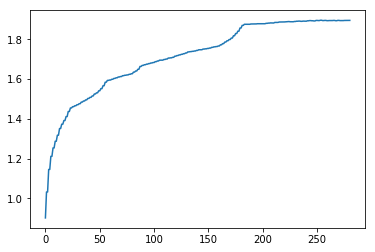

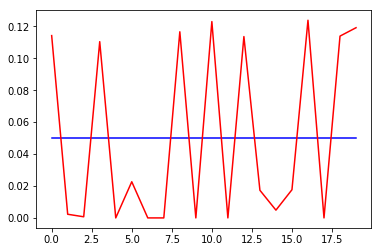

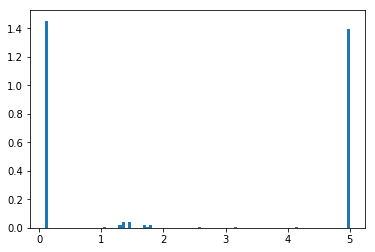

In [39]:
%matplotlib inline

plt.figure()
plt.plot(info_list)

plt.figure()
plt.plot(weight_list[0], c='b')
plt.plot(weight_list[-1], c='r')

plt.figure()
_ = plt.hist(tuning.reshape(-1), bins = 100, weights = np.array(list(weight)*tuning.shape[0]))

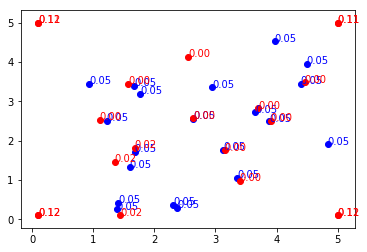

In [40]:
plt.figure()
plt.scatter(tuning_list[0][0,:],tuning_list[0][1,:], c='b')
for i in range(numBin):
    plt.text(tuning_list[0][0,i],tuning_list[0][1,i], '%.2f'%weight_list[0][i], color='b')
    
plt.scatter(tuning_list[-1][0,:],tuning_list[-1][1,:], c='r')
for i in range(numBin):
    plt.text(tuning_list[-1][0,i],tuning_list[-1][1,i], '%.2f'%weight_list[-1][i], color='r')

/home/zliu/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


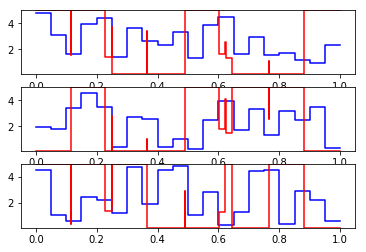

In [41]:
fig = plt.figure()
_ = plot_funcs_in_figure(fig, tuning_list[0], weight_list[0], nrow=numNeuro, ncol=1, 
                               fp = fp + 0.01, fm = fm - 0.01, color = 'b')

_ = plot_funcs_in_figure(fig, tuning_list[-1], weight_list[-1], nrow=numNeuro, ncol=1, 
                               fp = fp + 0.01, fm = fm - 0.01, color = 'r')

In [42]:
FILE_NAME = "poisson_example_dim_%d_fp=%d_"%(numNeuro,fp)+ time.strftime("%m%d-%H%M%S")
# FILE_NAME = FILE_NAME + '_conti'
res_dict = {}
# res_dict['inv_cov'] = inv_cov_matrix # for gaussian
res_dict['tuning'] = tuning_list
res_dict['weight'] = weight_list
res_dict['grad'] = grad_list
res_dict['info'] = info_list
res_dict['mark'] = mark_list

res_dict['sgd_learning_rate'] = sgd_learning_rate_list
res_dict['sgd_batch_size'] = sgd_batch_size_list
res_dict['sgd_iter_steps'] = sgd_iter_steps_list
res_dict['ba_batch_size'] = ba_batch_size_list
res_dict['ba_iter_steps'] = ba_iter_steps_list
res_dict['laplacian_coeff'] = laplacian_coeff_list

res_dict['time'] = time_list
res_dict['num_threads'] = NUM_THREADS

print(FILE_NAME)
np.save(FILE_NAME, res_dict)

poisson_example_dim_3_fp=5_0606-183910


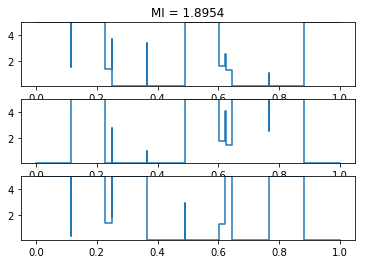

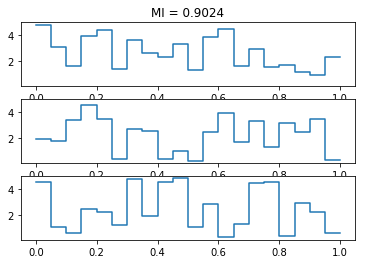

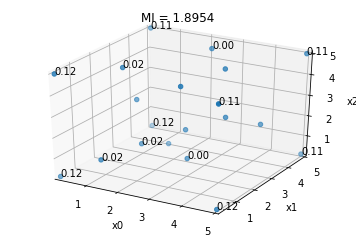

<Figure size 432x288 with 0 Axes>

In [43]:
fig = plt.figure()
ax_list = plot_funcs_in_figure(fig, tuning, weight, nrow=numNeuro, ncol=1, 
                               fp = fp + 0.01, fm = fm - 0.01)
ax_list[0].set_title('MI = %.4f'% info_list[-1])
plt.savefig(FILE_NAME+'.jpg')

fig = plt.figure()
ax_list = plot_funcs_in_figure(fig, tuning_list[0], weight_list[0], ncol = 1, nrow = numNeuro, 
                               fp = fp + 0.01, fm = fm - 0.01)
ax_list[0].set_title('MI = %.4f'% info_list[0])
plt.savefig(FILE_NAME+'_initial.jpg')


ANNOTE_WEIGHTS = True
from mpl_toolkits.mplot3d import Axes3D, proj3d
if numNeuro ==2 :
    plt.figure()
    plt.scatter(tuning[0,:], tuning[1,:])
    plt.xlim([fm - 0.01, fp + 0.01])
    plt.ylim([fm - 0.01, fp + 0.01])
    if ANNOTE_WEIGHTS:
        for i in range(numBin):
            plt.text(tuning[0,i], tuning[1,i], '%.2f'%weight[i])
elif numNeuro == 3:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tuning[0,:], tuning[1,:], tuning[2,:])

    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('x2')
    ax.set_xlim([fm - 0.01, fp + 0.01])
    ax.set_ylim([fm - 0.01, fp + 0.01])
    ax.set_zlim([fm - 0.01, fp + 0.01])
    if ANNOTE_WEIGHTS:
        for i in range(numBin):
            if weight[i] > 1e-3:
                x_, y_, _ = proj3d.proj_transform(tuning[0,i], tuning[1,i], tuning[2,i], ax.get_proj())
                ax.text2D(x_,y_, '%.2f'%weight[i], fontsize = 10)

    ax.set_title('MI = %.4f'% info_list[-1])
    plt.show()
    plt.savefig(FILE_NAME+'_points.jpg')

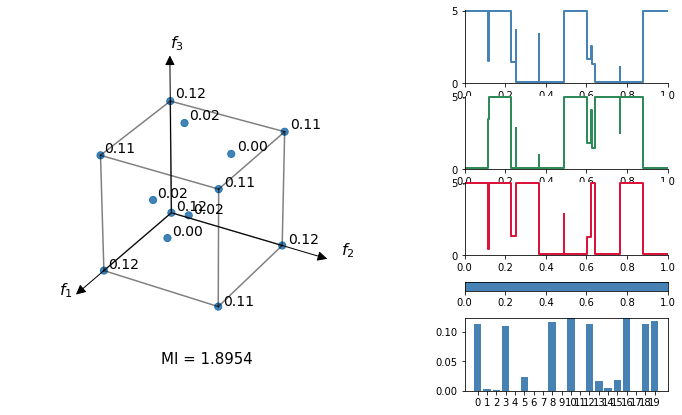

In [46]:
## if using python 3

from tuning.anim_3dcube import get_color_array, gen_mixed_plots, gen_mixed_anim

my_color_array = np.tile(matplotlib.colors.to_rgba('steelblue'), [numBin, 1])
# my_color_array = get_color_array(numBin)

_ = gen_mixed_plots(tuning, weights=weight, info=info_list[-1],
                    radius=fp, min_radius=fm,
                    color_arr=my_color_array,
                    point_size=50,                    
#                     INCLUDE_FUN=False, INCLUDE_WEIGHT=False, INCLUDE_WEIGHT_BAR=False, # default to be True
                    FILE_NAME=FILE_NAME, ADD_TIME=False,
#                     info_format = "MI = %.4f",
#                     weight_tol=1e-3, weight_format='%.2f',
#                     path_vec=None,
#                     path_close=True, path_color='crimson', linestyle='dashed',
                   )


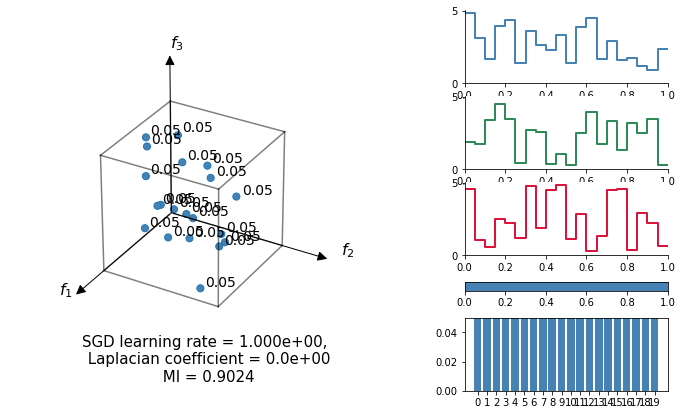

In [47]:
info_str = "SGD learning rate = %.3e, \n Laplacian coefficient = %.1e"%(
    sgd_learning_rate_list[1], LAPLACIAN_COEFF)


anim = \
gen_mixed_anim(tuning_list, weights_list=weight_list, info_list=info_list,
               point_size = 50,
               radius=fp, min_radius=fm,
#                INCLUDE_FUN=False, INCLUDE_WEIGHT=False, INCLUDE_WEIGHT_BAR=False, # default to be True
               FILE_NAME=FILE_NAME, ADD_TIME=False,
               interval=1000,# depends on average time of each sgd step or ba step
               info_format = info_str+"\n "+"MI = %.4f",
               color_arr_list=[my_color_array]*len(info_list),
#                path_vec_list=None,
#                color_arr_list=None,
              )